# <center> Предсказание пола клиента </center>

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [1]:
import numpy as np
import pandas as pd

In [2]:
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")

transactions = pd.read_csv("data/transactions.csv")
gender = pd.read_csv("data/gender.csv", index_col="customer_id")

In [3]:
tr_mcc_codes.info()
tr_mcc_codes.head()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 742 to 9402
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mcc_description  184 non-null    object
dtypes: object(1)
memory usage: 2.9+ KB


,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело


In [12]:
tr_types.info()
tr_types.head()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 3200 to 3120
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tr_description  155 non-null    object
dtypes: object(1)
memory usage: 2.4+ KB


,tr_description
tr_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...


In [6]:
transactions.info()
transactions.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849346 entries, 0 to 6849345
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   tr_datetime  object 
 2   mcc_code     int64  
 3   tr_type      int64  
 4   amount       float64
 5   term_id      object 
dtypes: float64(1), int64(3), object(2)
memory usage: 313.5+ MB


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124
6849345,61870738,454 18:06:30,6011,7010,408756.67,372701


In [7]:
gender.info()
gender.tail(3)

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 6740969 to 82234503
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gender  8400 non-null   float64
dtypes: float64(1)
memory usage: 187.5 KB


,gender
customer_id,
70027904,NaN
16393345,NaN
82234503,NaN


In [4]:
# Объединение данных по идентификатору клиента
merged_df = pd.merge(transactions, gender, on="customer_id", how="left")

In [5]:
# Объединение данных по mcc_code
merged_df = pd.merge(merged_df, tr_mcc_codes, on="mcc_code", how="left")
merged_df

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0,"Звонки с использованием телефонов, считывающих..."
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0,Финансовые институты — снятие наличности автом...
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0,Денежные переводы
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1.0,"Различные продовольственные магазины — рынки, ..."
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1.0,"Различные продовольственные магазины — рынки, ..."
...,...,...,...,...,...,...,...,...
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113,0.0,"Различные продовольственные магазины — рынки, ..."
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915,0.0,"Бакалейные магазины, супермаркеты"
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113,0.0,"Различные продовольственные магазины — рынки, ..."
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124,0.0,Станции техобслуживания


In [6]:
# Объединение данных по tr_type
merged_df = pd.merge(merged_df, tr_types, on="tr_type", how="left")
merged_df

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,tr_description
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы СБ РФ
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0,Финансовые институты — снятие наличности автом...,Взнос наличных через АТМ (в своем тер.банке)
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0,Денежные переводы,Списание с карты по операции “перевода с карты...
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1.0,"Различные продовольственные магазины — рынки, ...",Покупка. POS ТУ СБ РФ
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1.0,"Различные продовольственные магазины — рынки, ...",Покупка. POS ТУ СБ РФ
...,...,...,...,...,...,...,...,...,...
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113,0.0,"Различные продовольственные магазины — рынки, ...",Покупка. POS ТУ СБ РФ
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915,0.0,"Бакалейные магазины, супермаркеты",Покупка. POS ТУ СБ РФ
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113,0.0,"Различные продовольственные магазины — рынки, ...",Покупка. POS ТУ СБ РФ
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124,0.0,Станции техобслуживания,Покупка. POS ТУ Россия


In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849346 entries, 0 to 6849345
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   customer_id      int64  
 1   tr_datetime      object 
 2   mcc_code         int64  
 3   tr_type          int64  
 4   amount           float64
 5   term_id          object 
 6   gender           float64
 7   mcc_description  object 
 8   tr_description   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 470.3+ MB


In [8]:
# Подсчет уникальных значений в столбцах
unique_customer_id = merged_df['customer_id'].nunique()
unique_mcc_code = merged_df['mcc_code'].nunique()
unique_tr_type = merged_df['tr_type'].nunique()

# Вывод результатов
print(f"Уникальных значений в столбце 'customer_id': {unique_customer_id}")
print(f"Уникальных значений в столбце 'mcc_code': {unique_mcc_code}")
print(f"Уникальных значений в столбце 'tr_type': {unique_tr_type}")

Уникальных значений в столбце 'customer_id': 15000
Уникальных значений в столбце 'mcc_code': 184
Уникальных значений в столбце 'tr_type': 77


In [18]:
merged_df['day_number'] = merged_df['tr_datetime'].str.split(' ').str[0]



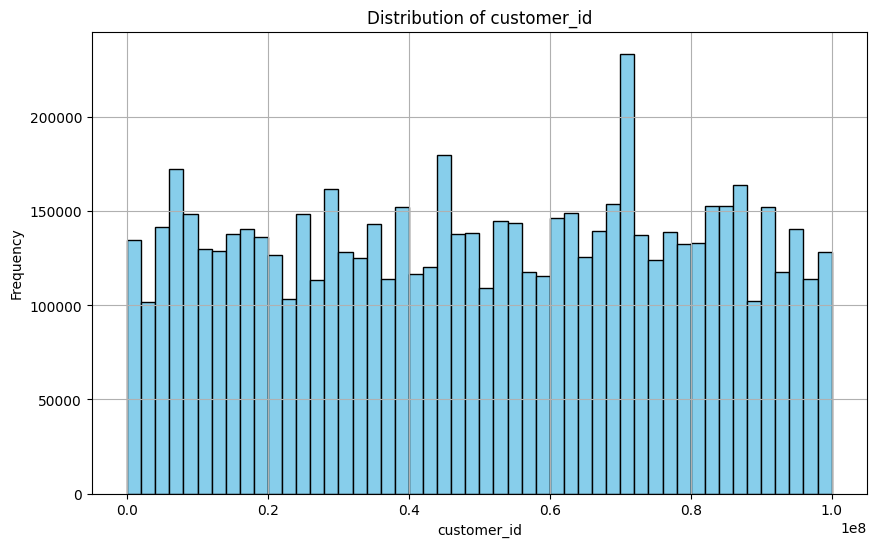

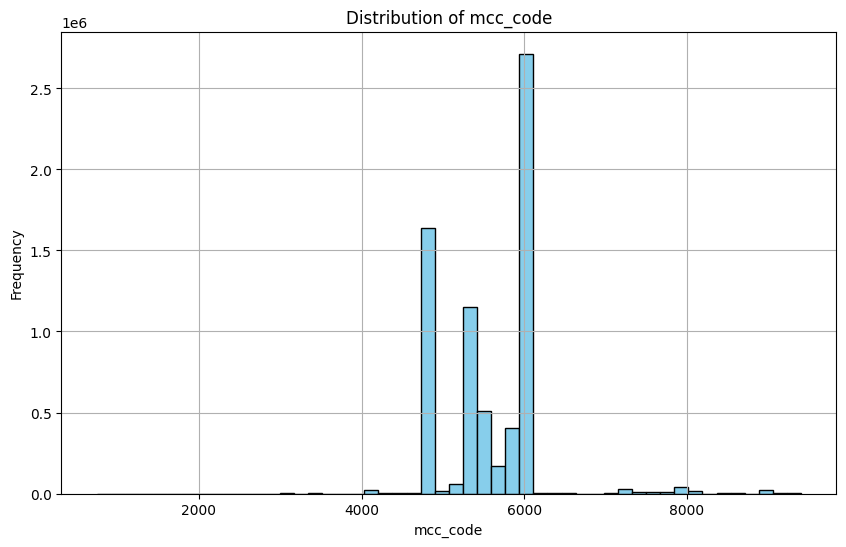

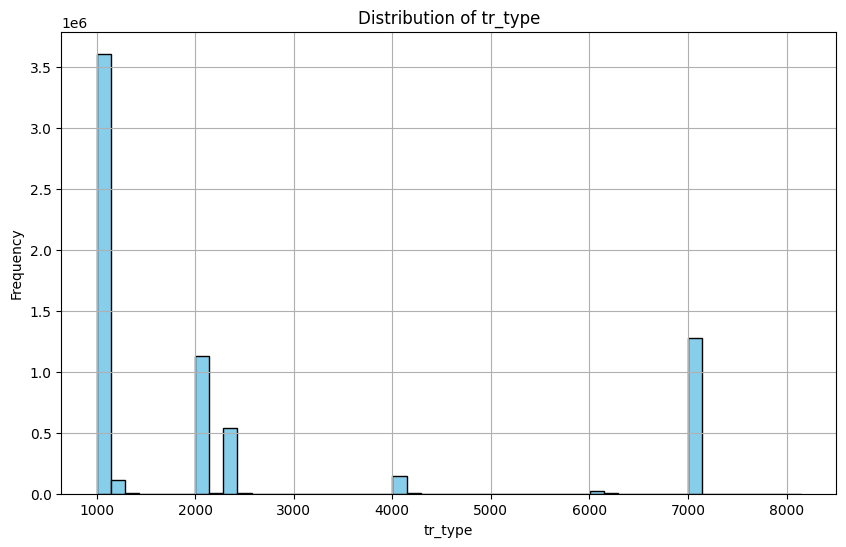

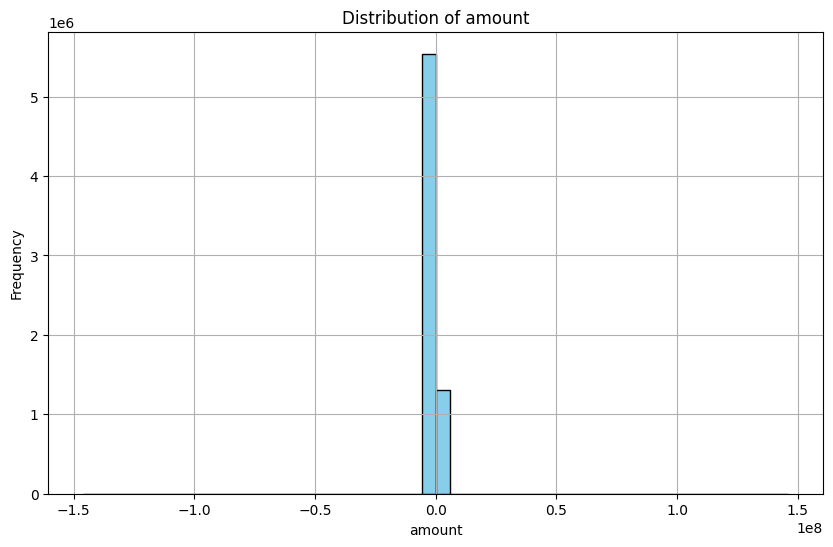

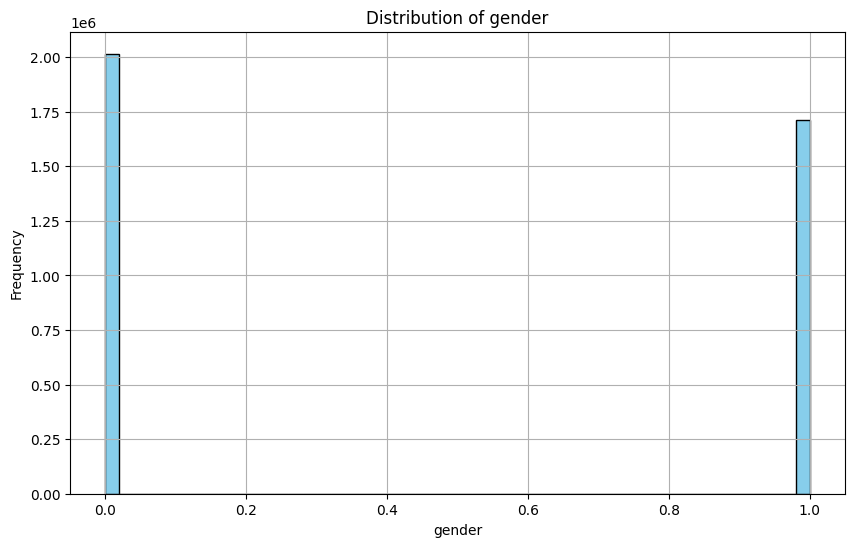

In [9]:
import matplotlib.pyplot as plt

# Выбор числовых признаков
numeric_features = ['customer_id', 'mcc_code', 'tr_type', 'amount', 'gender']

# Построение гистограмм для каждого числового признака
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    plt.hist(merged_df[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [10]:
print(merged_df[merged_df['amount'].isnull()])

Empty DataFrame
Columns: [customer_id, tr_datetime, mcc_code, tr_type, amount, term_id, gender, mcc_description, tr_description]
Index: []


In [12]:
# Преобразование строки в формат даты и времени с указанием формата
merged_df['tr_datetime'] = pd.to_datetime(merged_df['tr_datetime'], format='%d %H:%M:%S')


# Извлечение дня и часа из столбца tr_datetime
merged_df['day'] = merged_df['tr_datetime'].dt.day
merged_df['hour'] = merged_df['tr_datetime'].dt.hour

# Агрегация по клиентам, дням и часам
aggregated_data = merged_df.groupby(['customer_id', 'day', 'hour']).agg({
    'amount': ['sum', 'mean', 'std'],  # Сумма, среднее и стандартное отклонение суммы транзакций
    'mcc_code': 'nunique',             # Количество уникальных MCC-кодов
    'tr_type': 'nunique',              # Количество уникальных типов транзакций
    'gender': 'first'
})

# Переименование столбцов для удобства
aggregated_data.columns = ['total_amount', 'mean_amount', 'std_amount', 'unique_mcc_codes', 'unique_tr_types', 'gender']

# Сброс мультииндекса
aggregated_data = aggregated_data.reset_index()

# Проверка полученного датафрейма
print(aggregated_data.head())


ValueError: time data "0 10:23:26" doesn't match format "%d %H:%M:%S", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [29]:
aggregated_data.head()

,total_amount,mean_amount,std_amount,unique_mcc_codes,unique_tr_types,gender
customer_id,,,,,,
6815,-1249454.87,-5528.561372,168370.985787,6,6,NaN
22899,-629796.59,-2691.438419,127851.642622,11,21,1.0
27914,-2977026.82,-26820.061441,104675.148673,6,7,1.0
28753,-26546282.86,-90293.479116,785586.199773,30,15,0.0
31385,-2180003.58,-5972.612548,33418.557369,17,17,0.0


In [30]:
aggregated_data['std_amount'].fillna(0, inplace=True)

In [31]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 6815 to 99999680
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_amount      15000 non-null  float64
 1   mean_amount       15000 non-null  float64
 2   std_amount        15000 non-null  float64
 3   unique_mcc_codes  15000 non-null  int64  
 4   unique_tr_types   15000 non-null  int64  
 5   gender            8400 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 820.3 KB


In [32]:
print(aggregated_data[aggregated_data['std_amount'].isnull()])

Empty DataFrame
Columns: [total_amount, mean_amount, std_amount, unique_mcc_codes, unique_tr_types, gender]
Index: []


In [33]:
# Разделение данных на обучающую и тестовую выборки
train_data = aggregated_data[aggregated_data['gender'].notnull()]
test_data = aggregated_data[aggregated_data['gender'].isnull()]

# Удаление столбца 'gender' из тестовой выборки
test_data.drop('gender', axis=1, inplace=True)

# Проверка размеров обучающей и тестовой выборок
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (8400, 6)
Test data shape: (6600, 5)


/tmp/ipykernel_14691/2447516268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop('gender', axis=1, inplace=True)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Определение признаков и целевой переменной
X = train_data.drop('gender', axis=1)
y = train_data['gender']

# Создание модели логистической регрессии
model = LogisticRegression()

# Вычисление ROC AUC с помощью кросс-валидации
roc_auc_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Вывод результатов
print("ROC AUC на кросс-валидации (cv=5):", roc_auc_scores)
print("Среднее ROC AUC:", roc_auc_scores.mean())


ROC AUC на кросс-валидации (cv=5): [0.62355699 0.5579828  0.58288029 0.59847742 0.58430647]
Среднее ROC AUC: 0.5894407912459354


In [37]:
from catboost import CatBoostClassifier

# Создание модели CatBoost Classifier
catboost_model = CatBoostClassifier()

# Вычисление ROC AUC с помощью кросс-валидации
roc_auc_scores_catboost = cross_val_score(catboost_model, X, y, cv=5, scoring='roc_auc')

# Вывод результатов
print("ROC AUC на кросс-валидации для CatBoost Classifier (cv=5):", roc_auc_scores_catboost)
print("Среднее ROC AUC для CatBoost Classifier:", roc_auc_scores_catboost.mean())


Learning rate set to 0.023239
0:	learn: 0.6917854	total: 48.2ms	remaining: 48.2s
1:	learn: 0.6905443	total: 49.7ms	remaining: 24.8s
2:	learn: 0.6893414	total: 51.7ms	remaining: 17.2s
3:	learn: 0.6881589	total: 54ms	remaining: 13.4s
4:	learn: 0.6870656	total: 56.1ms	remaining: 11.2s
5:	learn: 0.6859532	total: 58.1ms	remaining: 9.63s
6:	learn: 0.6848499	total: 60.2ms	remaining: 8.54s
7:	learn: 0.6838081	total: 62.6ms	remaining: 7.76s
8:	learn: 0.6827672	total: 64.8ms	remaining: 7.14s
9:	learn: 0.6818806	total: 67ms	remaining: 6.64s
10:	learn: 0.6809857	total: 69.1ms	remaining: 6.21s
11:	learn: 0.6801079	total: 70.6ms	remaining: 5.81s
12:	learn: 0.6792059	total: 72.4ms	remaining: 5.5s
13:	learn: 0.6784326	total: 74.2ms	remaining: 5.22s
14:	learn: 0.6777182	total: 76.2ms	remaining: 5s
15:	learn: 0.6769171	total: 78ms	remaining: 4.8s
16:	learn: 0.6761738	total: 80.7ms	remaining: 4.67s
17:	learn: 0.6755623	total: 82.7ms	remaining: 4.51s
18:	learn: 0.6748299	total: 84.8ms	remaining: 4.38s
19: